# 03. Learning LangGraph - Agent Supervisor

In [ ]:
!pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.7/165.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata


os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "LangGraph 03 Multi-agent Supervisor"

## The model

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-1106-preview")

## Tools

In [ ]:
from typing import Annotated, List, Tuple, Union
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
import random

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [ ]:
# my custom tools
@tool("lower_case", return_direct=False)
def to_lower_case(input:str) -> str:
  """Returns the input as all lower case."""
  return input.lower()

@tool("random_number", return_direct=False)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100. input the word 'random'"""
    return random.randint(0, 100)

tools = [to_lower_case,random_number_maker,python_repl_tool]

## Helper Utils

In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [ ]:
# agent node
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

## Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [ ]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Lotto_Manager", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Create the Agnet State and Graph

In [ ]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


lotto_agent = create_agent(llm, tools, "You are a senior lotto manager. you run the lotto and get random numbers")
lotto_node = functools.partial(agent_node, agent=lotto_agent, name="Lotto_Manager")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(llm, [python_repl_tool], "You may generate safe python code to analyze data and generate charts using matplotlib.")
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Lotto_Manager", lotto_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

### Edges

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor") # add one edge for each of the agents

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

Run it

{'supervisor': {'next': 'Lotto_Manager'}}
----


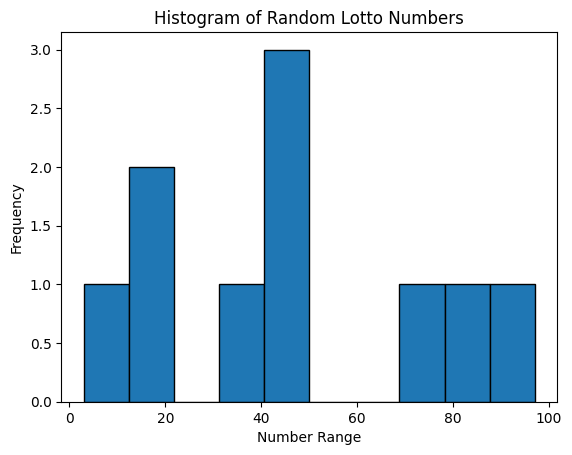

{'Lotto_Manager': {'messages': [HumanMessage(content="I have generated 10 random lotto numbers and plotted them on a histogram. However, I'm unable to directly display images or plots here. You can run the Python code I used in your local environment to see the histogram. Here's the Python code for reference:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Define the numbers\nnumbers = [97, 20, 32, 69, 82, 3, 47, 49, 48, 14]\n\n# Plot the histogram\nplt.hist(numbers, bins=10, edgecolor='black')\nplt.title('Histogram of Random Lotto Numbers')\nplt.xlabel('Number Range')\nplt.ylabel('Frequency')\n\n# Show the plot\nplt.show()\n```\n\nAnd the 10 random lotto numbers are:\n1. 97\n2. 20\n3. 32\n4. 69\n5. 82\n6. 3\n7. 47\n8. 49\n9. 48\n10. 14\n\nYou can use this code to plot the histogram on your machine to visualize the distribution of these random numbers.", name='Lotto_Manager')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
config = {"recursion_limit": 20}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
):
    if "__end__" not in s:
        print(s)
        print("----")

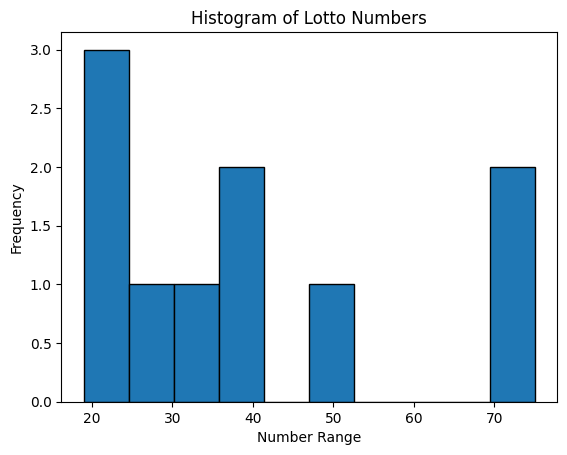

In [ ]:
final_response = graph.invoke(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
)

In [ ]:
final_response

{'messages': [HumanMessage(content='Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end'),
  HumanMessage(content='The histogram has been plotted using the following lotto numbers:\n\n- 70\n- 75\n- 37\n- 19\n- 38\n- 29\n- 34\n- 50\n- 22\n- 19\n\nUnfortunately, I cannot directly display images here, but the histogram was created with 10 bins, each representing a range of numbers, and the frequency of the numbers falling into each bin is depicted. You can recreate the histogram using any software that supports plotting, such as Python with Matplotlib, using the numbers provided above.', name='Lotto_Manager')],
 'next': 'FINISH'}

In [ ]:
final_response['messages'][1].content

'The histogram has been plotted using the following lotto numbers:\n\n- 70\n- 75\n- 37\n- 19\n- 38\n- 29\n- 34\n- 50\n- 22\n- 19\n\nUnfortunately, I cannot directly display images here, but the histogram was created with 10 bins, each representing a range of numbers, and the frequency of the numbers falling into each bin is depicted. You can recreate the histogram using any software that supports plotting, such as Python with Matplotlib, using the numbers provided above.'